In [19]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizerFast, DataCollatorForLanguageModeling
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append("../VAE_standard")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE

from matplotlib import pyplot as plt

sys.path.append("..")
import utils

from Bio import SeqIO
from Bio.Seq import Seq

from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

from ex2_hamming_vs_influence import get_ex2_data
import pickle
import pandas as pd

In [14]:
MAX_TOKEN_LENGTH = 510
BATCH_SIZE=60
BIF_BATCH_SIZE=80
num_masks = 3

TEST_SEQ = 1
# TRAIN_CUTOFF = 3000
# TEST_TOKEN = 0

DEVICE = "cuda"

In [15]:
"""
tokenizer: 
input_ids - torch.LongTensor of shape (batch_size, sequence_length)
attention_mask - torch.Tensor of shape (batch_size, sequence_length), Mask values selected in {0,1}, where 0 := masked, 1 := not masked
"""

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="pt")

model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(DEVICE)

## Data Preparation

In [16]:
data = get_ex2_data(tokenizer)
aa_drop_na = data["aa_drop_na"]
names_drop_na = data["names_drop_na"]
unique_aa_seqs = data["unique_aa_seqs"]
train_data = data["train_data"]
bif_data = data["bif_data"]

num_obs = len(bif_data)
num_data = len(bif_data)

done extracting sequences!
done extracting AAs!


In [17]:
def collate_fn(batch, data_collator=data_collator, device=DEVICE):
    batch = torch.stack(batch, dim=0)
    inputs, labels = data_collator.torch_mask_tokens(batch)
    return inputs.to(device), labels.to(DEVICE)

sgld_dataloader = torch.utils.data.DataLoader(train_data, collate_fn=collate_fn, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)
bif_dataloader = torch.utils.data.DataLoader(bif_data, collate_fn=collate_fn, shuffle=False, batch_size=BIF_BATCH_SIZE, drop_last=False)

### Goal: understand the relationship between $BIF(z_i,z_j)$ and $||z_i - z_j||_1$ i.e. hamming distance 

In [7]:
def get_vals(
    model, 
    dataloader=bif_dataloader, 
    vocab_size=tokenizer.vocab_size,
    num_data = len(unique_aa_seqs),
    batch_size = BIF_BATCH_SIZE
):  
    """
    model (torch.nn.module): ESM model
    dataloader (torch.utils.data.DataLoader): sequence data used to calculate loss vector and observables (in this case, loss_vec = obs)
    vocab_size (int): number of distinct tokens used by tokenizer i.e. # classes
    num_data (int): length of loss vector and observables
    batch_size (int): batch size of dataloader

    returns:
    crossentropy losses that represents loss vector and observables
    """
    ret_vec = torch.zeros(num_data)

    with torch.no_grad():
        for i, (b_input, b_label) in enumerate(dataloader):
            bsize = b_input.shape[0]
            outputs = model(b_input, attention_mask=torch.ones_like(b_input))["logits"]
            batch_loss = torch.sum(nn.functional.cross_entropy(outputs.view(-1,vocab_size), target=b_label.view(-1), ignore_index=-100, reduction="none").view(bsize, -1), dim=-1)
    
            if i < len(dataloader) - 1:
                ret_vec[i * batch_size : (i+1) * batch_size] = batch_loss
            else:
                ret_vec[i * batch_size:] = batch_loss

    return ret_vec
    

In [8]:
def evaluate_function(
    model: nn.Module, 
    data: torch.Tensor, 
    device=DEVICE, 
) -> EvalResults:
    
    """
    model (torch.nn.module): ESM model
    data (torch.Tensor): minibatch data used to update weights of model in SGLD
    device (String): either "cuda" or "cpu"

    returns:
    dictionary with 
    (i) loss - loss used to update weights of model
    (ii) obs - calculated observables (in this case cross-entropy loss on one test token) as described above
    (iii) loss_vec - the losses evaluated at every training point for the model used to compute the BIF as described in the BIF algorithm 
    """
    
    inputs, targets = data
    vals = get_vals(model=model)
    return {
        "loss": model(inputs, labels=targets).loss,
        "obs": vals,
        "loss_vec": vals
    }

In [9]:
ESM_BIF = estimate_bif(
    model=model,
    loader = sgld_dataloader,
    evaluate = evaluate_function,
    num_obs=num_obs,
    device=DEVICE,
    num_chains=4,
    num_draws=20,
    num_data=num_data
)

/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:262: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:266: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:311: UserWarning: If you're setting a nbeta or temperature in sampling_method_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:61: UserWarning: You are taking more sample bat

## Visualizations

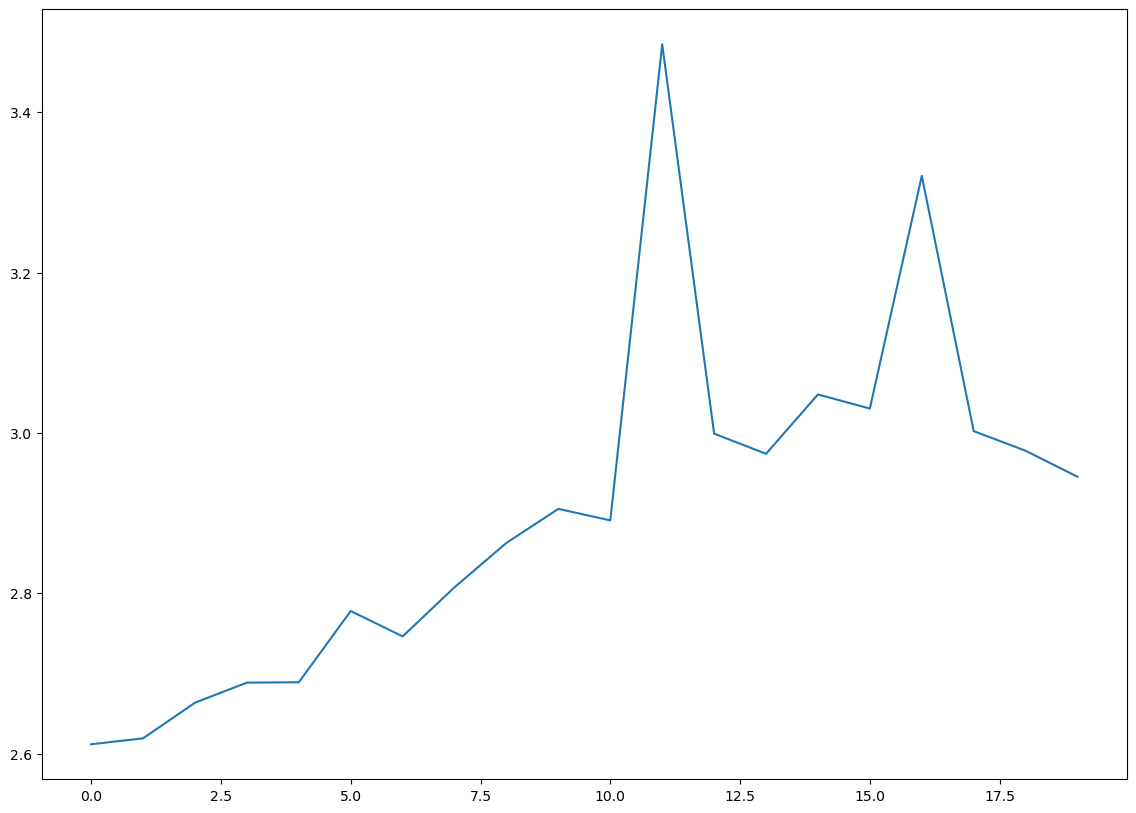

In [10]:
fig, arr = plt.subplots(1,1,figsize=(14,10))

losses = ESM_BIF["sgld_loss/trace"]
arr.plot(np.arange(losses.shape[1]), losses[0])
plt.show()

In [20]:
lower_tri_indices = torch.torch.tril_indices(num_data,num_data,offset=-1)
computed_bif_matrix = ESM_BIF["BIF"]
hamming_dist = torch.sum(((bif_data[None,:,:] - bif_data[:,None,:]) != 0), dim=-1).numpy()

# computed_bif = np.diag(computed_bif)
# hamming_dist = np.diag(hamming_dist)

computed_bif = computed_bif_matrix[lower_tri_indices[0], lower_tri_indices[1]]
hamming_dist = hamming_dist[lower_tri_indices[0], lower_tri_indices[1]]

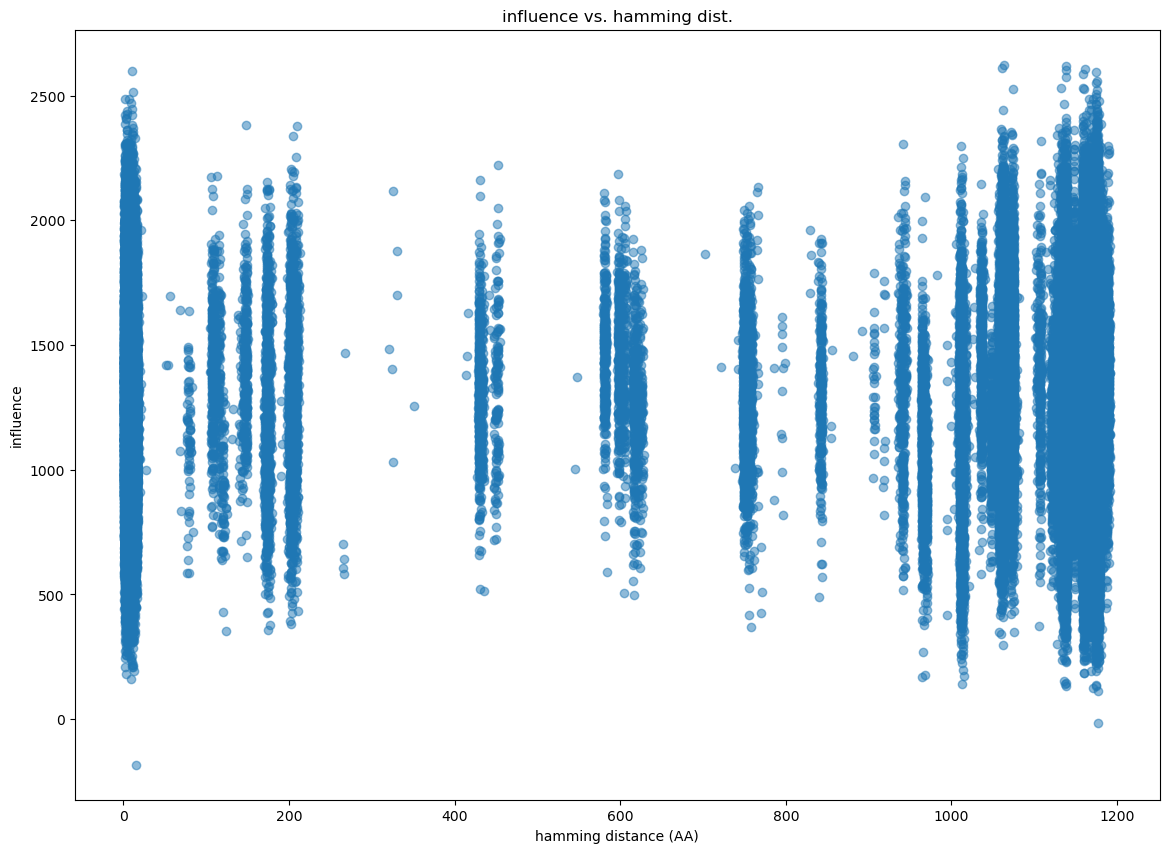

In [21]:
fig,ax = plt.subplots(1,1,figsize=(14,10))
ax.scatter(hamming_dist, computed_bif, alpha=0.5)
ax.set_xlabel("hamming distance (AA)")
ax.set_ylabel("influence")
ax.set_title("influence vs. hamming dist.")
# ax.set_xlim([0, 1200])
plt.show()

In [24]:
with open("ex2_computed_influences.pkl","wb") as file:
    pickle.dump((computed_bif_matrix, unique_aa_seqs), file) 